**Классификация изображений с помощью сверточных нейронных сетей**

В данном задании Вам необходимо разработать архитектуру сверточной ИНС, обеспечивающую наибольшую точность при ограничении на количество операций (FLOPs <= 0.707e6).
Заготовка кода для выполнения задания приведена выше. Вашей задачей будет заполнить пропущеные места, которые отмечены ключевым словом *None*.
Необходимая точность (accuracy) сети на датасете CIFAR100 - 30%
Желаемая точность (accuracy) сети на датасете CIFAR100 - 45%

In [16]:
!pip install keras-flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_flops import get_flops

In [18]:
# Глобальные константы
CLASSES       = 100
BATCH_SIZE    = 128
LEARNING_RATE = 1e-2

In [19]:
# Выполните загрузку модели
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar100.load_data()

In [20]:
# Преобразуйте метки классов в one_hot формат
y_train = (y_train == np.arange(CLASSES)).astype(np.float32)
y_val = (y_val == np.arange(CLASSES)).astype(np.float32)

In [21]:
# убедитесь, что данная ячейка выполняется без ошибок
assert X_train.shape == (50000, 32, 32, 3)
assert X_val.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 100)
assert y_val.shape == (10000, 100)

In [22]:
# Задайте архитектуру модели
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=[32, 32, 3]),

    tf.keras.layers.Conv2D(30, kernel_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(24, kernel_size=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(CLASSES),
    tf.keras.layers.Activation('softmax'),
])

In [23]:
# вычисление количества операций
flops = get_flops(model, batch_size=1)
print(f"FLOPs: {(flops / 1e6):.4f}e6")

FLOPs: 0.6706e6


In [24]:
# вывод краткой информации о модели
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        390       
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 30)       120       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 16, 16, 30)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 24)          2904      
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 24)        

In [25]:
# параметры данной ячейки могут быть изменены для получения более высокой точности
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=LEARNING_RATE,
            decay_steps=1500,
            decay_rate=0.5
        )
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
# обучения модели
result = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath="{epoch:02d}-{val_accuracy:.2f}.hdf5", save_best_only=True)
    ],
    use_multiprocessing=True,
    workers=8,
    epochs=40
)

Epoch 1/40
391/391 [==============================] - 3s 6ms/step - loss: 3.5411 - accuracy: 0.1782 - val_loss: 3.2927 - val_accuracy: 0.2123
Epoch 2/40
391/391 [==============================] - 2s 5ms/step - loss: 3.0333 - accuracy: 0.2631 - val_loss: 3.0271 - val_accuracy: 0.2687
Epoch 3/40
391/391 [==============================] - 2s 6ms/step - loss: 2.8707 - accuracy: 0.2939 - val_loss: 2.9251 - val_accuracy: 0.2923
Epoch 4/40
391/391 [==============================] - 3s 9ms/step - loss: 2.7498 - accuracy: 0.3167 - val_loss: 2.7694 - val_accuracy: 0.3217
Epoch 5/40
391/391 [==============================] - 4s 10ms/step - loss: 2.6705 - accuracy: 0.3326 - val_loss: 2.7015 - val_accuracy: 0.3287
Epoch 6/40
391/391 [==============================] - 4s 9ms/step - loss: 2.6111 - accuracy: 0.3452 - val_loss: 2.8878 - val_accuracy: 0.2959
Epoch 7/40
391/391 [==============================] - 2s 6ms/step - loss: 2.5644 - accuracy: 0.3550 - val_loss: 2.6007 - val_accuracy: 0.3531
Epoch

In [27]:
scores = model.evaluate(X_val, y_val, verbose=0) 
print(f"Model accuracy: {scores[1]:.4f}")

Model accuracy: 0.3957


Визуализируем процесс обучения

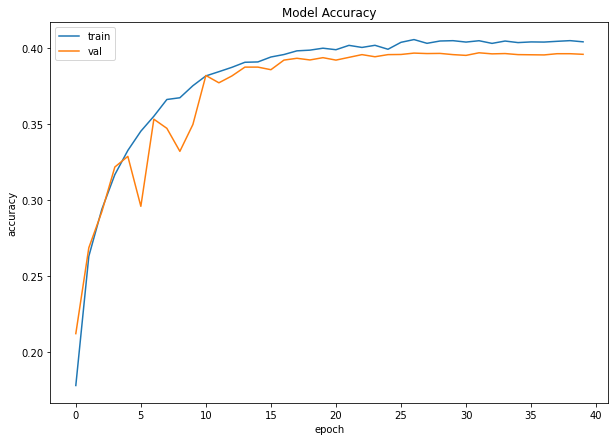

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

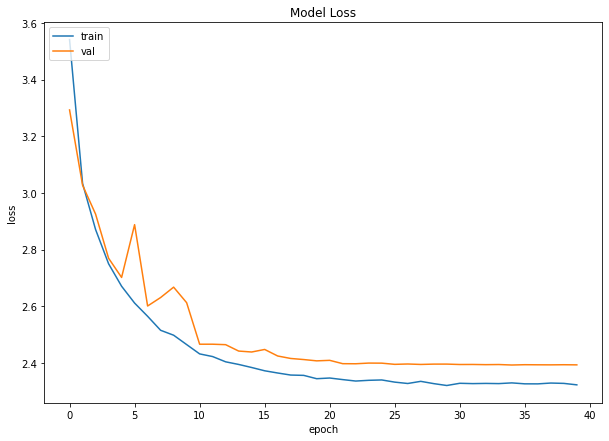

In [29]:
plt.figure(figsize=(10, 7))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Заметно, что оптимальная точность модели достигается примерно на 25-й эпохе.